In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)

Files already downloaded and verified


In [3]:
def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std

def load_data(is_train,aug,batch_size):
  dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
#   mean, std = get_mean_and_std(dataset)
#   print(mean, std)
  dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
  return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6
[[[-0.9147032  -0.38956204  0.0274618  ...  0.01201648  0.18191507
    0.15102442]
  [-0.32778072 -0.03431951  0.10468844 ... -0.21966343  0.1973604
    0.2591417 ]
  [-0.09610081  0.29003236  0.24369638 ... -0.6366873  -0.51312464
   -0.32778072]
  ...
  [ 1.0931895   1.2321974   1.448432   ...  0.22825105  0.66072035
    1.6646665 ]
  [ 1.2013068   1.3248694   1.3866507  ... -0.38956204 -0.17332745
    1.1704161 ]
  [ 1.3866507   1.2785335   1.1549708  ... -0.8529219  -0.8065859
    0.7997283 ]]

 [[-1.2393323  -0.8772444  -0.53089947 ... -0.5151565  -0.3419841
   -0.3419841 ]
  [-0.8142726  -0.6725861  -0.5623854  ... -0.68832904 -0.32624117
   -0.29475525]
  [-0.6411001  -0.42069885 -0.45218474 ... -1.003188   -0.9244732
   -0.76704377]
  ...
  [ 0.57110703  0.6813077   0.9804237  ... -0.21604052  0.19327614
    1.2323109 ]
  [ 0.6025929   0.74427944  0.8229942  ... -0.83001554 -0.68832904
    0.6655647 ]
  [ 0.87022305  0.8072512   0.6340788  ... -1.12913

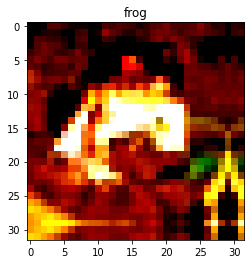

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
image_= np.array(image).copy()
print(image.shape, label)
print(image_)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [5]:
# trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=batch_size,shuffle=True)
# testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=batch_size,shuffle=False)

# images, labels = iter(trainDataLoader).next()
# plt.figure(figsize=(17,8))
# for index in np.arange(0,5):
#   plt.subplot(1,5,index+1)
#   plt.imshow(images[index].numpy().transpose(1,2,0))
#   plt.title(str(classes[labels[index]]))

def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std


In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, in_planes, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_planes*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, in_planes*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, in_planes*8, num_blocks[3], stride=2)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, self.in_planes*8, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
#     return ResNet(BasicBlock, [2, 2, 2])
    return ResNet(64, BasicBlock, [2, 1, 1, 1])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4977226


In [8]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
num_epochs = 5000 # param
epoch_start = 0
# path = 'adam_rotate_center_crop1.pt'
# path = 'block_3.pt'
path = 'batch_256_lr_0.1-0.0003_no_crop_decay_layer_4.pt'

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()
lr = 0.1 # param
lr_min=0.0003
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
# optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimizer
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)

# torch.cuda.empty_cache()

if os.path.exists(path):
  checkpoint = torch.load(path)
  print('Read model from checkpoint')
  model1.cuda().load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_start = checkpoint['epoch']
  Loss = checkpoint['Loss']
  train_loss_history = checkpoint['train_loss_history']
  test_loss_history = checkpoint['test_loss_history']
  test_accuracy_history = checkpoint['test_accuracy_history']
  train_accuracy_history = checkpoint['train_accuracy_history']
  print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs + 1):
  timestart = time.time()

  train_loss = 0.0
  test_loss = 0.0
  test_accuracy = 0.0
  train_accuracy = 0.0

  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = model1.cuda()(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
    optimizer.step()
    train_loss += fit.item()
    train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model1.cuda()(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
      test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  test_accu = test_accuracy/len(testDataLoader)
  train_accu = train_accuracy/len(trainDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accu)
  train_accuracy_history.append(train_accu)
  print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))
  
  if epoch % 5 == 0 and epoch != 0:
    torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'test_accuracy_history':test_accuracy_history,
          'train_accuracy_history':train_accuracy_history},path)
    print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 1.6958683242603225, Test loss 1.3806837737560271, Train accuracy 36.44491390306123, Test accuracy 48.623046875, Cost 52.98425054550171 s
Epoch 2, Train loss 1.234714140393296, Test loss 1.0628566503524781, Train accuracy 55.09088012150356, Test accuracy 61.11328125, Cost 52.8530912399292 s
Epoch 3, Train loss 0.993619658204974, Test loss 0.9073909446597099, Train accuracy 64.42801341231988, Test accuracy 67.40234375, Cost 53.23222279548645 s
Epoch 4, Train loss 0.8425330610907807, Test loss 0.7718627035617829, Train accuracy 70.06257971938776, Test accuracy 72.373046875, Cost 53.28929114341736 s
Epoch 5, Train loss 0.7296641253086985, Test loss 0.6771287500858307, Train accuracy 74.1342474489796, Test accuracy 76.73828125, Cost 52.968531131744385 s
Model saved in epoch 5
Epoch 6, Train loss 0.6455911451152393, Test loss 0.688456280529499, Train accuracy 77.50996492346938, Test accuracy 76.171875, Cost 52.80828666687012 s
Epoch 7, Train loss 0.5795086838152944, Test 

Epoch 52, Train loss 0.044660623099806965, Test loss 0.3475518271327019, Train accuracy 98.43072385204081, Test accuracy 91.19140625, Cost 52.806421756744385 s
Epoch 53, Train loss 0.04135513452965082, Test loss 0.34992541596293447, Train accuracy 98.54073660714286, Test accuracy 91.2890625, Cost 52.89557433128357 s
Epoch 54, Train loss 0.04300902569571472, Test loss 0.348308177292347, Train accuracy 98.49091198979592, Test accuracy 91.42578125, Cost 52.72988438606262 s
Epoch 55, Train loss 0.04095480690843293, Test loss 0.31938641276210544, Train accuracy 98.55389030612245, Test accuracy 92.20703125, Cost 52.954585552215576 s
Model saved in epoch 55
Epoch 56, Train loss 0.04258638160892439, Test loss 0.3414198011159897, Train accuracy 98.50805165816327, Test accuracy 91.552734375, Cost 52.754114866256714 s
Epoch 57, Train loss 0.0374964941483067, Test loss 0.3557001147419214, Train accuracy 98.73325892857143, Test accuracy 91.66015625, Cost 52.65010929107666 s
Epoch 58, Train loss 0.0

Epoch 102, Train loss 0.01071489938268704, Test loss 0.38384819217026234, Train accuracy 99.63926977040816, Test accuracy 92.138671875, Cost 52.88956832885742 s
Epoch 103, Train loss 0.012910329108957999, Test loss 0.3899435311555862, Train accuracy 99.58107461734694, Test accuracy 92.041015625, Cost 53.2630136013031 s
Epoch 104, Train loss 0.012543585006508748, Test loss 0.4036539115011692, Train accuracy 99.56114477040816, Test accuracy 92.001953125, Cost 53.002230167388916 s
Epoch 105, Train loss 0.011099588052887584, Test loss 0.3999206408858299, Train accuracy 99.6273118622449, Test accuracy 92.060546875, Cost 53.13326334953308 s
Model saved in epoch 105
Epoch 106, Train loss 0.009532796512405408, Test loss 0.38797331899404525, Train accuracy 99.66876594387755, Test accuracy 92.5, Cost 52.65365481376648 s
Epoch 107, Train loss 0.00866285495505174, Test loss 0.4202726274728775, Train accuracy 99.70902423469387, Test accuracy 91.884765625, Cost 52.64049959182739 s
Epoch 108, Train l

Epoch 152, Train loss 0.006405936730924604, Test loss 0.41981757432222366, Train accuracy 99.80070153061224, Test accuracy 92.431640625, Cost 72.69807004928589 s
Epoch 153, Train loss 0.007617832467076369, Test loss 0.41185767240822313, Train accuracy 99.74848533163265, Test accuracy 92.646484375, Cost 73.41634511947632 s
Epoch 154, Train loss 0.007208157422369089, Test loss 0.40919815599918363, Train accuracy 99.76881377551021, Test accuracy 92.822265625, Cost 72.97296714782715 s
Epoch 155, Train loss 0.0057295262816909115, Test loss 0.39594093561172483, Train accuracy 99.82661033163265, Test accuracy 92.40234375, Cost 72.5873281955719 s
Model saved in epoch 155
Epoch 156, Train loss 0.005482045960183759, Test loss 0.4145121119916439, Train accuracy 99.82661033163265, Test accuracy 92.44140625, Cost 73.03511166572571 s
Epoch 157, Train loss 0.006584146312480717, Test loss 0.4086099587380886, Train accuracy 99.76881377551021, Test accuracy 92.75390625, Cost 72.9635591506958 s
Epoch 158

Epoch 202, Train loss 0.0035583206276247176, Test loss 0.45407208129763604, Train accuracy 99.86846301020408, Test accuracy 92.275390625, Cost 71.63623261451721 s
Epoch 203, Train loss 0.003207768080867435, Test loss 0.43688751980662344, Train accuracy 99.90433673469387, Test accuracy 92.51953125, Cost 72.84289693832397 s
Epoch 204, Train loss 0.003960261762530331, Test loss 0.4250100690871477, Train accuracy 99.87005739795919, Test accuracy 92.646484375, Cost 73.20128774642944 s
Epoch 205, Train loss 0.006007638786416335, Test loss 0.44678438529372216, Train accuracy 99.79870854591837, Test accuracy 92.529296875, Cost 72.4879322052002 s
Model saved in epoch 205
Epoch 206, Train loss 0.003545637616613875, Test loss 0.43461525402963164, Train accuracy 99.90234375, Test accuracy 92.763671875, Cost 72.63146567344666 s
Epoch 207, Train loss 0.0032699895446985836, Test loss 0.4501406528055668, Train accuracy 99.89198022959184, Test accuracy 92.138671875, Cost 72.71497178077698 s
Epoch 208, 

Epoch 252, Train loss 0.001916264808623593, Test loss 0.4424997761845589, Train accuracy 99.94419642857143, Test accuracy 92.71484375, Cost 72.57619428634644 s
Epoch 253, Train loss 0.0021369760785203153, Test loss 0.4481050200760365, Train accuracy 99.93821747448979, Test accuracy 92.783203125, Cost 72.81480574607849 s
Epoch 254, Train loss 0.0017257219407318708, Test loss 0.4397007659077644, Train accuracy 99.94818239795919, Test accuracy 92.98828125, Cost 72.77820181846619 s
Epoch 255, Train loss 0.003288717047567212, Test loss 0.4775649294257164, Train accuracy 99.89437181122449, Test accuracy 92.5, Cost 72.28074169158936 s
Model saved in epoch 255
Epoch 256, Train loss 0.0019516181132066591, Test loss 0.4372675184160471, Train accuracy 99.9461894132653, Test accuracy 92.939453125, Cost 72.34447193145752 s
Epoch 257, Train loss 0.0012500148202016876, Test loss 0.46004172042012215, Train accuracy 99.97010522959184, Test accuracy 92.8515625, Cost 72.9769995212555 s
Epoch 258, Train l

Epoch 302, Train loss 0.0015894910924525532, Test loss 0.4716815710067749, Train accuracy 99.9461894132653, Test accuracy 92.4609375, Cost 72.58217740058899 s
Epoch 303, Train loss 0.002127570011564284, Test loss 0.44132166281342505, Train accuracy 99.9282525510204, Test accuracy 92.890625, Cost 73.0901849269867 s
Epoch 304, Train loss 0.0012845782302046784, Test loss 0.4437558762729168, Train accuracy 99.96213329081633, Test accuracy 92.55859375, Cost 71.9958930015564 s
Epoch 305, Train loss 0.0007081871340511609, Test loss 0.4502019174396992, Train accuracy 99.98804209183673, Test accuracy 92.822265625, Cost 73.24364495277405 s
Model saved in epoch 305
Epoch 306, Train loss 0.001818091183961268, Test loss 0.4559424340724945, Train accuracy 99.94419642857143, Test accuracy 92.55859375, Cost 72.82720732688904 s
Epoch 307, Train loss 0.0018159115101929163, Test loss 0.4560306616127491, Train accuracy 99.9461894132653, Test accuracy 92.724609375, Cost 72.25192523002625 s
Epoch 308, Train

Epoch 352, Train loss 0.0013950622198480027, Test loss 0.4542137634009123, Train accuracy 99.97010522959184, Test accuracy 92.96875, Cost 72.66461849212646 s
Epoch 353, Train loss 0.0013581948305913176, Test loss 0.4313602156471461, Train accuracy 99.9398118622449, Test accuracy 93.45703125, Cost 72.96681618690491 s
Epoch 354, Train loss 0.0008295369885041621, Test loss 0.44058663696050643, Train accuracy 99.98007015306122, Test accuracy 93.30078125, Cost 72.42540431022644 s
Epoch 355, Train loss 0.0011894355358138882, Test loss 0.44316796474158765, Train accuracy 99.96412627551021, Test accuracy 93.203125, Cost 72.66725397109985 s
Model saved in epoch 355
Epoch 356, Train loss 0.0014184929069712352, Test loss 0.44584309831261637, Train accuracy 99.95814732142857, Test accuracy 93.0859375, Cost 72.37935709953308 s
Epoch 357, Train loss 0.0019334657776412035, Test loss 0.4375629887334071, Train accuracy 99.9461894132653, Test accuracy 93.33984375, Cost 72.56922626495361 s
Epoch 358, Tra

Epoch 402, Train loss 0.0014245004843230294, Test loss 0.4768021207302809, Train accuracy 99.9561543367347, Test accuracy 92.9296875, Cost 72.75935077667236 s
Epoch 403, Train loss 0.0020785134379180743, Test loss 0.5162128195166588, Train accuracy 99.93781887755102, Test accuracy 92.763671875, Cost 73.04227423667908 s
Epoch 404, Train loss 0.0027765894291016074, Test loss 0.5047680921852589, Train accuracy 99.91230867346938, Test accuracy 92.587890625, Cost 72.56977939605713 s
Epoch 405, Train loss 0.0025612656451942583, Test loss 0.48108717426657677, Train accuracy 99.90832270408163, Test accuracy 93.06640625, Cost 72.17778396606445 s
Model saved in epoch 405
Epoch 406, Train loss 0.001239931533987425, Test loss 0.4826837692409754, Train accuracy 99.96014030612245, Test accuracy 92.91015625, Cost 72.83184385299683 s
Epoch 407, Train loss 0.0020427251749832957, Test loss 0.4818503983318806, Train accuracy 99.93622448979592, Test accuracy 92.880859375, Cost 72.53069257736206 s
Epoch 40

Epoch 452, Train loss 0.0003840679576068378, Test loss 0.4676787480711937, Train accuracy 99.99202806122449, Test accuracy 93.4375, Cost 72.8056218624115 s
Epoch 453, Train loss 0.0008996336837948807, Test loss 0.4686064891517162, Train accuracy 99.97209821428571, Test accuracy 93.02734375, Cost 72.50830268859863 s
Epoch 454, Train loss 0.0004907204398960505, Test loss 0.47382066026329994, Train accuracy 99.99003507653062, Test accuracy 93.203125, Cost 72.53670024871826 s
Epoch 455, Train loss 0.0011843845961442528, Test loss 0.4966356590390205, Train accuracy 99.9740911989796, Test accuracy 93.046875, Cost 72.86154699325562 s
Model saved in epoch 455
Epoch 456, Train loss 0.0004860545443209828, Test loss 0.4803770639002323, Train accuracy 99.99402104591837, Test accuracy 93.046875, Cost 72.68589401245117 s
Epoch 457, Train loss 0.00029526447975531853, Test loss 0.47725881561636924, Train accuracy 99.99402104591837, Test accuracy 93.26171875, Cost 72.29320478439331 s
Epoch 458, Train l

Epoch 502, Train loss 0.0006307879619326945, Test loss 0.47155984714627264, Train accuracy 99.98405612244898, Test accuracy 93.0859375, Cost 72.63948631286621 s
Epoch 503, Train loss 0.00086109235802705, Test loss 0.4780402254313231, Train accuracy 99.97010522959184, Test accuracy 92.958984375, Cost 72.5242292881012 s
Epoch 504, Train loss 0.0006441663341292394, Test loss 0.47726326547563075, Train accuracy 99.97608418367346, Test accuracy 93.154296875, Cost 72.28528356552124 s
Epoch 505, Train loss 0.0006044009514439773, Test loss 0.4641943149268627, Train accuracy 99.98405612244898, Test accuracy 93.115234375, Cost 72.6245608329773 s
Model saved in epoch 505
Epoch 506, Train loss 0.00031232723207889353, Test loss 0.47068185806274415, Train accuracy 99.99402104591837, Test accuracy 93.095703125, Cost 72.95272397994995 s
Epoch 507, Train loss 0.00042835767915128564, Test loss 0.470472302287817, Train accuracy 99.98804209183673, Test accuracy 93.06640625, Cost 72.44840598106384 s
Epoch 

Epoch 552, Train loss 0.000473657744476218, Test loss 0.48268836587667463, Train accuracy 99.98405612244898, Test accuracy 93.33984375, Cost 72.89079070091248 s
Epoch 553, Train loss 0.00048424468485795935, Test loss 0.48250008933246136, Train accuracy 99.98764349489795, Test accuracy 93.3984375, Cost 72.97482252120972 s
Epoch 554, Train loss 0.0005158564618141657, Test loss 0.48800480030477045, Train accuracy 99.98804209183673, Test accuracy 93.2421875, Cost 72.20379114151001 s
Epoch 555, Train loss 0.0004942341694266602, Test loss 0.5112013787031173, Train accuracy 99.98405612244898, Test accuracy 92.91015625, Cost 72.84982419013977 s
Model saved in epoch 555
Epoch 556, Train loss 0.0005801490301193405, Test loss 0.4964644737541676, Train accuracy 99.9820631377551, Test accuracy 93.14453125, Cost 72.8098874092102 s
Epoch 557, Train loss 0.0005683032824231769, Test loss 0.4938867688179016, Train accuracy 99.98804209183673, Test accuracy 93.076171875, Cost 72.3792130947113 s
Epoch 558,

In [ ]:
num_epochs = 500
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
# plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [ ]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)